# 2A.ml - Analyse de sentiments - correction

C'est désormais un problème classique de machine learning. D'un côté, du texte, de l'autre une appréciation, le plus souvent binaire, positive ou négative mais qui pourrait être graduelle.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Les données

On récupère les données depuis le site UCI [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) où on utilise la fonction ``load_sentiment_dataset``.

In [3]:
from ensae_teaching_cs.data import load_sentiment_dataset
df = load_sentiment_dataset()
df.head()

,sentance,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


## Exercice 1 : approche td-idf

La cible est la colonne *sentiment*, les deux autres colonnes sont les features. Il faudra utiliser les prétraitements [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [TF-IDF](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). L'un d'entre eux n'est pas nécessaire depuis la version [0.20.0](http://scikit-learn.org/stable/whats_new.html#sklearn-preprocessing) de *scikit-learn*. On s'occupe des variables catégorielles.

### La variable catégorielle

Ce serait un peu plus simple avec le module [Category Encoders](http://contrib.scikit-learn.org/categorical-encoding/) ou la dernière nouveauté de scikit-learn : [ColumnTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer).

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                df.drop("sentiment", axis=1), df["sentiment"])

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
le.fit(X_train["source"])
X_le = le.transform(X_train["source"])
X_le.shape

(2250,)

In [6]:
X_le_mat = X_le.reshape((X_le.shape[0], 1))

In [7]:
ohe = OneHotEncoder(categories="auto")
ohe.fit(X_le_mat)

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [8]:
X_le_encoded = ohe.transform(X_le_mat)
train_cat = X_le_encoded.todense()
test_cat = ohe.transform(le.transform(X_test["source"]).reshape((len(X_test), 1))).todense()

In [9]:
import pandas
X_train2 = pandas.concat([X_train.reset_index(drop=True),
                          pandas.DataFrame(train_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_train2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,The reception through this headset is excellent.,amazon_cells_labelled,1.0,0.0,0.0
1,John Wayne did an incredible job for being so ...,imdb_labelled,0.0,1.0,0.0


In [10]:
X_test2 = pandas.concat([X_test.reset_index(drop=True),
                         pandas.DataFrame(test_cat, columns=le.classes_)],
                         sort=False, axis=1)
X_test2.head(n=2)

,sentance,source,amazon_cells_labelled,imdb_labelled,yelp_labelled
0,But even the talented Carrell can't save this.,imdb_labelled,0.0,1.0,0.0
1,Jamie Foxx absolutely IS Ray Charles.,imdb_labelled,0.0,1.0,0.0


### tokenisation

On tokenise avec le module [spacy](https://spacy.io/usage/spacy-101#annotations-token) qui requiert des données supplémentaires pour découper en mot avec ``pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.0.0/en_core_web_sm-2.0.0.tar.gz`` selon les instructions dévoilées dans le [guide de départ](https://spacy.io/usage/models) ou encore ``python -m spacy download en``. Le module [gensim](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/artificiel_tokenize.html?highlight=tokenisation#gensim) ne requiert pas d'installation. On peut aussi s'inspirer de l'example [word2vec pré-entraînés](http://www.xavierdupre.fr/app/papierstat/helpsphinx/notebooks/text_sentiment_wordvec.html#word2vec-pre-entraines).

In [11]:
import en_core_web_sm
nlp = en_core_web_sm.load()

c:\python370_x64\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
c:\python370_x64\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [12]:
doc = nlp(X_train2.iloc[0,0])
[token.text for token in doc]

['The', 'reception', 'through', 'this', 'headset', 'is', 'excellent', '.']

### tf-idf

Une fois que les mots sont tokenisé, on peut appliquer le *tf-idf*.

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import make_pipeline
tokenizer = lambda text: [token.text.lower() for token in nlp(text)]
count = CountVectorizer(tokenizer=tokenizer, analyzer='word')
tfidf = TfidfTransformer()
pipe = make_pipeline(count, tfidf)

In [14]:
pipe.fit(X_train["sentance"])

Pipeline(memory=None,
     steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
  ...'tfidftransformer', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True))])

In [15]:
train_feature = pipe.transform(X_train2["sentance"])
train_feature

<2250x4410 sparse matrix of type '<class 'numpy.float64'>'
	with 29252 stored elements in Compressed Sparse Row format>

In [16]:
test_feature = pipe.transform(X_test2["sentance"])

### Combinaison de toutes les variables

In [17]:
train_feature.shape, train_cat.shape

((2250, 4410), (2250, 3))

In [18]:
import numpy
np_train = numpy.hstack([train_feature.todense(), train_cat])
np_test = numpy.hstack([test_feature.todense(), test_cat])

### Calage d'un modèle

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50)
rf.fit(np_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
rf.score(np_test, y_test)

0.776

## Exercice 2 : word2vec

On utilise l'approche [word2vec](https://en.wikipedia.org/wiki/Word2vec) du module [gensim](https://radimrehurek.com/gensim/models/word2vec.html) ou [spacy](https://spacy.io/usage/vectors-similarity). Avec [spacy](https://spacy.io/usage/vectors-similarity), c'est assez simple :

In [22]:
vv = nlp(X_train2.iloc[0, 0])
list(vv)[0].vector[:10], vv.vector.shape

(array([ 0.51015913,  2.4971437 , -1.1966136 ,  4.0078526 , -0.9308405 ,
        -0.44855446, -0.353467  ,  2.5924177 ,  1.1353339 ,  2.8435297 ],
       dtype=float32), (384,))

On fait la somme.

In [23]:
sum([_.vector for _ in vv])[:10]

array([  4.4440403 ,   6.2368155 ,   1.500057  ,  19.963652  ,
         1.4626558 ,   1.4041358 , -11.393349  ,  -0.02471632,
         9.648635  ,   6.3697495 ], dtype=float32)

In [24]:
np_train_vect = numpy.zeros((X_train2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_train2["sentance"]):
    np_train_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [25]:
np_test_vect = numpy.zeros((X_test2.shape[0], vv.vector.shape[0]))
for i, sentance in enumerate(X_test2["sentance"]):
    np_test_vect[i, :] = sum(v.vector for v in nlp(sentance.lower()))

In [26]:
np_train_v = numpy.hstack([np_train_vect, train_cat])
np_test_v = numpy.hstack([np_test_vect, test_cat])

In [27]:
rfv = RandomForestClassifier(n_estimators=50)
rfv.fit(np_train_v, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [28]:
rfv.score(np_test_v, y_test)

0.6546666666666666

Moins bien...

## Exercice 3 : comparer les deux approches

Avec une courbe [ROC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) par exemple.

In [29]:
pmodel1 = rf.predict_proba(np_test)[:, 1]
pmodel2 = rfv.predict_proba(np_test_v)[:, 1]

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
fpr1, tpr1, th1 = roc_curve(y_test, pmodel1)
fpr2, tpr2, th2 = roc_curve(y_test, pmodel2)

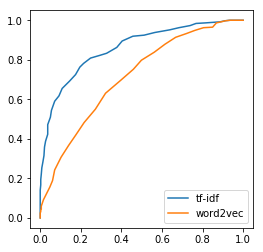

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(fpr1, tpr1, label='tf-idf')
ax.plot(fpr2, tpr2, label='word2vec')
ax.legend();

## Petite analyse d'erreurs

On combine les erreurs des modèles sur la base de test.

In [32]:
final = X_test.copy()
final["model1"] = pmodel1
final["model2"] = pmodel2
final["label"] = y_test
final.head()

,sentance,source,model1,model2,label
44,But even the talented Carrell can't save this.,imdb_labelled,0.14,0.40,0
209,Jamie Foxx absolutely IS Ray Charles.,imdb_labelled,0.60,0.52,1
398,Non-linear narration thus many flashbacks and ...,imdb_labelled,0.86,0.60,1
848,Lots of holes in the script.,imdb_labelled,0.30,0.62,0
953,It didn't charge for me.,amazon_cells_labelled,0.34,0.34,0


On regarde des erreurs.

In [33]:
erreurs = final[final["label"] == 1].sort_values("model2")
erreurs.head()

,sentance,source,model1,model2,label
944,"However, after finally watching this film, I r...",imdb_labelled,0.50,0.24,1
716,It quit working after I'd used it for about 18...,amazon_cells_labelled,0.60,0.26,1
817,You will leave the theater wanting to go out a...,imdb_labelled,0.52,0.28,1
50,I'm glad the film didn't go for the most obvio...,imdb_labelled,0.24,0.28,1
58,The salad had just the right amount of sauce t...,yelp_labelled,0.26,0.28,1


In [34]:
list(erreurs["sentance"])[:5]

['However, after finally watching this film, I realized that not only had I had a closed mind to the brilliance it depicts, I also found myself watching it over and over again.  ',
 "It quit working after I'd used it for about 18 months, so I just purchased another one because this is the best headset I've ever owned.",
 'You will leave the theater wanting to go out and dance under the stars.  ',
 "I'm glad the film didn't go for the most obvious choice, as a lesser film certainly would have.  ",
 'The salad had just the right amount of sauce to not over power the scallop, which was perfectly cooked.']

Le modèle 2 reconnaît mal les négations visiblement. On regarde le modèle 1.

In [35]:
erreurs = final[final["label"] == 1].sort_values("model1")
erreurs.head()

,sentance,source,model1,model2,label
323,I was able to do voice dialing in the car with...,amazon_cells_labelled,0.14,0.30,1
414,I would have casted her in that role after rea...,imdb_labelled,0.16,0.34,1
680,"I gave it 5 stars then, and I'm giving it 5 st...",yelp_labelled,0.16,0.48,1
658,It was just not a fun experience.,yelp_labelled,0.18,0.40,1
545,"No shifting, no bubbling, no peeling, not even...",amazon_cells_labelled,0.20,0.52,1


In [36]:
list(erreurs["sentance"])[:5]

['I was able to do voice dialing in the car with no problem.',
 'I would have casted her in that role after ready the script.  ',
 "I gave it 5 stars then, and I'm giving it 5 stars now.",
 'It was just not a fun experience.',
 "No shifting, no bubbling, no peeling, not even a scratch, NOTHING!I couldn't be more happier with my new one for the Droid."]

Idem, voyons là où les modèles sont en désaccords.

In [37]:
final["diff"] = final.model1 - final.model2

In [38]:
erreurs = final[final["label"] == 1].sort_values("diff")
erreurs.head()

,sentance,source,model1,model2,label,diff
418,First time going but I think I will quickly be...,yelp_labelled,0.24,0.60,1,-0.36
545,"No shifting, no bubbling, no peeling, not even...",amazon_cells_labelled,0.20,0.52,1,-0.32
680,"I gave it 5 stars then, and I'm giving it 5 st...",yelp_labelled,0.16,0.48,1,-0.32
20,I can think of no other film where something v...,imdb_labelled,0.28,0.58,1,-0.30
939,I like the fact that it rests lightly against ...,amazon_cells_labelled,0.24,0.52,1,-0.28


In [39]:
erreurs.tail()

,sentance,source,model1,model2,label,diff
320,I am also very happy with the price.,amazon_cells_labelled,0.92,0.52,1,0.40
887,Best headset ever!!!.,amazon_cells_labelled,0.88,0.48,1,0.40
61,All in all I give this one a resounding 9 out ...,imdb_labelled,0.72,0.30,1,0.42
234,Great place to have a couple drinks and watch ...,yelp_labelled,0.86,0.42,1,0.44
599,"For the price on Amazon, it is an excellent pr...",amazon_cells_labelled,0.84,0.36,1,0.48


Le modèle 2 (word2vec) a l'air meilleur sur les phrases longues, le modèle 1 (tf-idf) saisit mieux les mots positifs. A confirmer sur plus de données. 

* Enlever les stop words, les signes de ponctuation.
* Combiner les deux approches.
* n-grammes
* ...

Dernière analyse en regardant le taux d'erreur par source.

In [40]:
r1 = rf.predict(np_test)
r2 = rfv.predict(np_test_v)
final["rep1"] = r1
final["rep2"] = r2
final["err1"] = (final.label - final.rep1).abs()
final["err2"] = (final.label - final.rep2).abs()
final["total"] = 1
final.head()

,sentance,source,model1,model2,label,diff,rep1,rep2,err1,err2,total
44,But even the talented Carrell can't save this.,imdb_labelled,0.14,0.40,0,-0.26,0,0,0,0,1
209,Jamie Foxx absolutely IS Ray Charles.,imdb_labelled,0.60,0.52,1,0.08,1,1,0,0,1
398,Non-linear narration thus many flashbacks and ...,imdb_labelled,0.86,0.60,1,0.26,1,1,0,0,1
848,Lots of holes in the script.,imdb_labelled,0.30,0.62,0,-0.32,0,1,0,1,1
953,It didn't charge for me.,amazon_cells_labelled,0.34,0.34,0,0.00,0,0,0,0,1


In [41]:
final[["source", "err1", "err2", "total"]].groupby("source").sum()

,err1,err2,total
source,,,
amazon_cells_labelled,54,75,245
imdb_labelled,60,95,253
yelp_labelled,54,89,252


*imdb* paraît une source une peu plus difficile à saisir. Quoiqu'il en soit, 2000 phrases pour apprendre est assez peu pour apprendre.